## Import relevant libraries and functions

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle

from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator, 
    perform_experiments,
    Samplers, Constant,
    RealParameter, Scenario
)
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.analysis import (feature_scoring, pairs_plotting)

from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

## Prepare model and parameters

In [2]:
ema_logging.log_to_stderr(ema_logging.INFO)

# choose problem formulation number, between 0-5
# each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(2)

# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
import copy

for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

## Define zero policy

In [3]:
# defining specific policies

def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}

zeropolicy = Policy("zero policy",**dict(get_do_nothing_dict()))

## Run and save open exploration experiments

In [4]:
n_exp = 3000

with MultiprocessingEvaluator(dike_model) as evaluator:
    sa_results = evaluator.perform_experiments(scenarios=n_exp, policies=50, uncertainty_sampling=Samplers.LHS)

experiments, outcomes = sa_results

experiments.to_pickle('experiments_LHS_3000x50')

with open('outcomes_LHS_3000x50', 'wb') as f:
    pickle.dump(outcomes, f)

[MainProcess/INFO] pool started with 4 workers
[MainProcess/INFO] performing 3000 scenarios * 50 policies * 1 model(s) = 150000 experiments
100%|████████████████████████████████| 150000/150000 [9:11:52<00:00,  4.53it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [8]:
with open('experiments_LHS_3000x50', 'rb') as file:
    experiments_LH_3000x50 = pickle.load(file)
    
with open('outcomes_LHS_3000x50', 'rb') as file:
    outcomes_LH_3000x50 = pickle.load(file)

In [15]:
outcomes_LH_3000x50

{'Expected Annual Damage': array([ 1336686.55165002,  6032064.23732718,        0.        , ...,
         3529229.01831296, 36357361.13284222,  1790421.49792822]),
 'Dike Investment Costs': array([8.34338709e+08, 8.34338709e+08, 8.34338709e+08, ...,
        6.14959645e+08, 6.14959645e+08, 6.14959645e+08]),
 'RfR Investment Costs': array([1.1170e+09, 1.1170e+09, 1.1170e+09, ..., 1.2516e+09, 1.2516e+09,
        1.2516e+09]),
 'Evacuation Costs': array([ 51.80570649, 334.03210756,   0.        , ...,   0.        ,
          0.        ,   0.        ]),
 'Expected Number of Deaths': array([8.50606506e-05, 9.96951156e-04, 0.00000000e+00, ...,
        4.70450688e-03, 6.64075925e-02, 4.76807151e-03])}

In [29]:
outcomes_LH_3000x50['Expected Number of Deaths'].mean()

0.01550916884998848

## Analyse open exploration

[MainProcess/INFO] no time dimension found in results


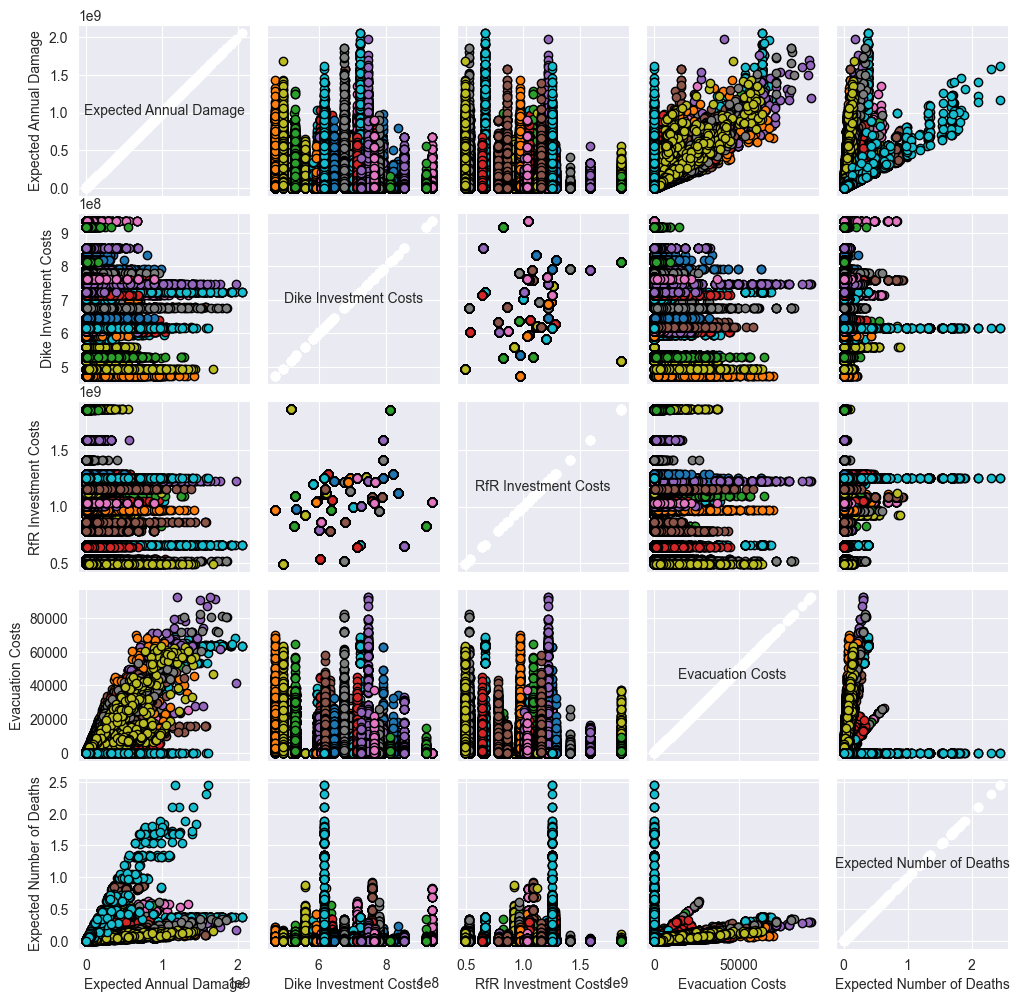

In [6]:
fig, axes = pairs_plotting.pairs_scatter(experiments_SOBOL_OE_SA, outcomes_SOBOL_OE_SA, group_by='policy', legend=False)
fig.set_size_inches(12, 12)
plt.show()

## Feature scoring

In [ ]:
fs = feature_scoring.get_feature_scores_all(experiments_SOBOL_OE_SA, outcomes_SOBOL_OE_SA)
sns.heatmap(fs, cmap="viridis", annot=True)
plt.show()

## Analyse SOBOL sensitivity

The following values are used for the ‘reference
scenario’: {'Bmax': 175, 'Brate': 1.5, 'pfail': 0.5, 'discount rate': 2.5, 'ID flood wave shape': 4}.
These values are not extreme values, but can be seen as an average scenario.

In [25]:
reference_scenario = Scenario('Reference Scenario', **dict({
    'discount rate 0': 2.5,
    'discount rate 1': 2.5,
    'discount rate 2': 2.5,
    'A.0_ID flood wave shape': 4,
    'A.1_Bmax': 175,
    'A.2_Bmax': 175,
    'A.3_Bmax': 175,
    'A.4_Bmax': 175,
    'A.5_Bmax': 175,
    'A.1_pfail': 0.5,
    'A.2_pfail': 0.5,
    'A.3_pfail': 0.5,
    'A.4_pfail': 0.5,
    'A.5_pfail': 0.5,
    'A.1_Brate': 1.5,
    'A.2_Brate': 1.5,
    'A.3_Brate': 1.5,
    'A.4_Brate': 1.5,
    'A.5_Brate': 1.5
}))

In [ ]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    sa_results = evaluator.perform_experiments(scenarios=reference_scenario, policies=5000, lever_sampling=Samplers.SOBOL)

experiments, outcomes = sa_results

experiments.to_pickle('experiments_SOBOL_1x5000')

with open('outcomes_SOBOL_1x5000', 'wb') as f:
    pickle.dump(outcomes, f)

[MainProcess/INFO] pool started with 4 workers
C:\Users\Asus\Documents\Python venvs\MBDMv2\Lib\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
[MainProcess/INFO] performing 1 scenarios * 320000 policies * 1 model(s) = 320000 experiments
  0%|                                  | 107/320000 [00:51<18:24:52,  4.83it/s]